<a href="https://colab.research.google.com/github/RodrigodeFeo/8DTS/blob/main/Plataformas_Azure_MonitoramentosBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Este documento nos apóia a realizar e conhecer a análise de desvio das variáveis utilizadas em um modelo.

Em uma plataforma corporativa, este trabalho é automatizado, mas neste laboratório faremos passo a passo para compreensão do que estamos realizando.

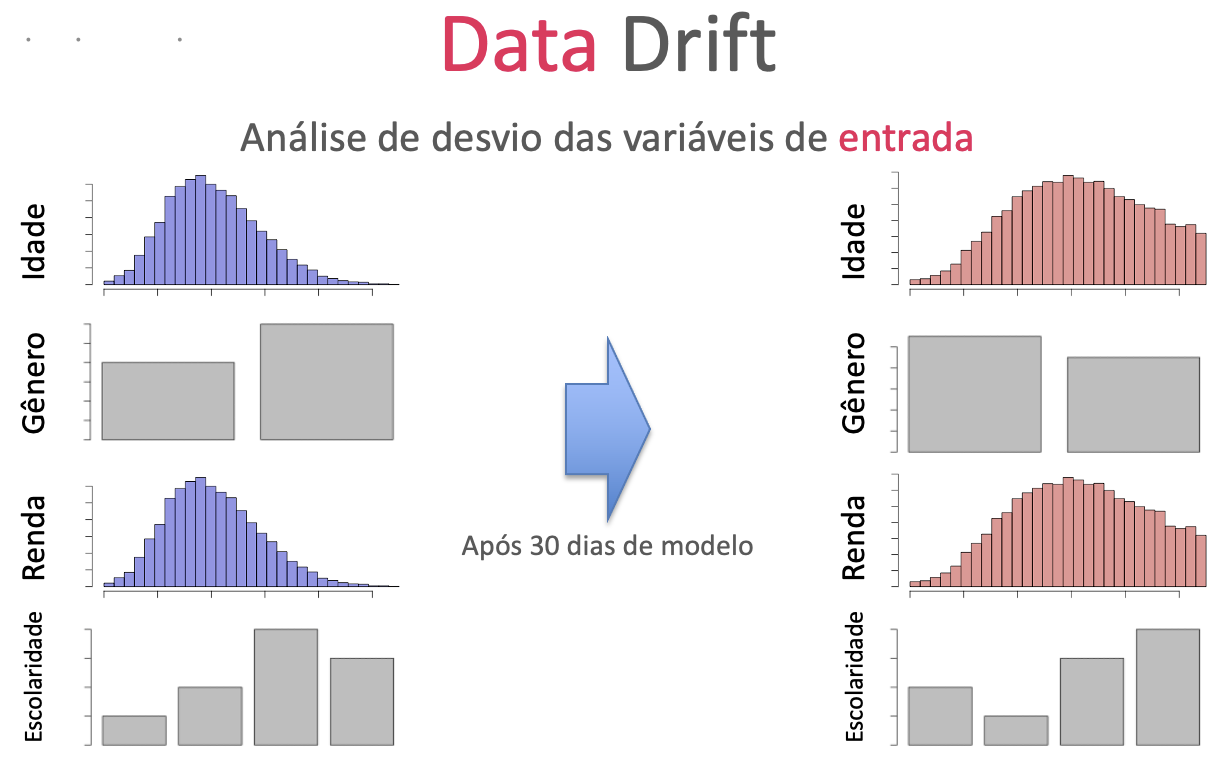

# Tarefa



O documento a seguir avalia DataDrift (desvio dos dados) entre o baseline e o mês anterior.

Explore com o professor e avalie como é feito um processo simples de monitoramento de DataDrift.

Na seqüencia, faça você a análise de desvio dos dados presentes no mês atual.

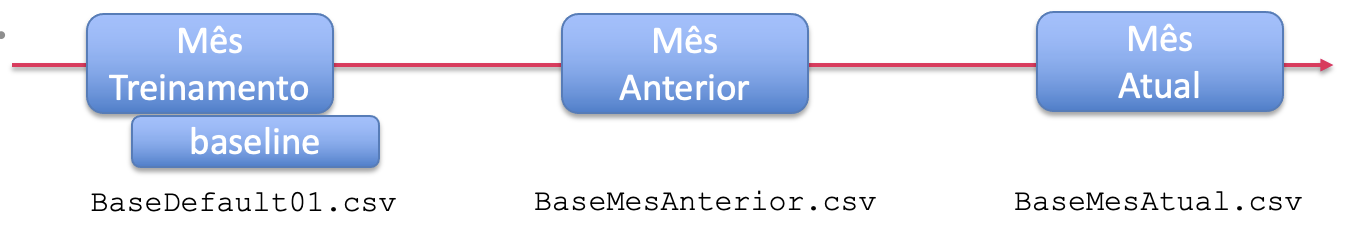

#Setup



In [1]:
!git clone https://github.com/elthonf/azure-ml.git

Cloning into 'azure-ml'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 274 (delta 20), reused 10 (delta 4), pack-reused 239 (from 1)
Receiving objects: 100% (274/274), 11.99 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (147/147), done.
Updating files: 100% (36/36), done.


Bibliotecas auxiliares

In [2]:
import numpy as np
import pandas as pd
import math, random, json
from scipy.stats.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

<ipython-input-2-9738a6f71b81>:4: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


Funções auxuliares

In [8]:
def describe(df):
    return pd.concat([df.describe(include="all", percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9]).T,
                      df.dtypes.rename('dtypes'),
                     # df.mad().rename('mad'),
                      #df.skew().rename('skew'),
                      #df.kurt().rename('kurt'),
                      df.nunique().rename('nunique'),
                     ], axis=1)
def describe_cols(df, df_summary=None):
  if df_summary is None:
    df_summary = describe(df)
  ret = {}
  for i, row in df_summary.iterrows():
    if row["nunique"] <= 100:
      ret[i] = {"classes" : json.loads( df.groupby([i]).size().to_json() ) }
    elif np.issubdtype(row["dtypes"], np.number):
      _h = np.histogram(df[i])
      _h2 = np.histogram(df[i], density=True)
      ret[i] = {"hist": list(_h[0]),
                "density": list(_h2[0]),
                "bin_edges": list(_h[1]),
                "bin_edgesv2": [-np.inf] + list(_h[1][1:-1]) + [np.inf] }
    else:
      ret[i] = {}
  return ret

# Obtenção de Dados

## Obter referência (baseline)

In [9]:
mybase = pd.read_csv("./azure-ml/datasets/statistical/BaseDefault01.csv")

In [10]:
mybase_metadata = describe(mybase)
mybase_counts = describe_cols(mybase, mybase_metadata)
mybase_metadata

count unique             top freq         mean         std  \
nome            100000  96546  Andrew, Nguyen   10          NaN         NaN   
renda         100000.0    NaN             NaN  NaN  3549.511518  804.766033   
idade         100000.0    NaN             NaN  NaN    38.819483   11.330192   
etnia         100000.0    NaN             NaN  NaN       0.4766    0.499455   
sexo          100000.0    NaN             NaN  NaN      0.47714     0.49948   
casapropria   100000.0    NaN             NaN  NaN       0.4744    0.499347   
outrasrendas  100000.0    NaN             NaN  NaN      0.23312     0.42282   
estadocivil   100000.0    NaN             NaN  NaN      0.58106    0.493388   
escolaridade  100000.0    NaN             NaN  NaN      1.72235     0.87798   
default       100000.0    NaN             NaN  NaN      0.45068    0.497564   

                     min          10%          20%          25%  ...  \
nome                 NaN          NaN          NaN          NaN  ...   
renda         1008.14707  2433.267828  2847.749606  2999.406891  ...   
idade           18.00046    22.506054    28.118952    30.203688  ...   
etnia                0.0          0.0          0.0          0.0  ...   
sexo                 0.0          0.0          0.0          0.0  ...   
casapropria          0.0          0.0          0.0          0.0  ...   
outrasrendas         0.0          0.0          0.0          0.0  ...   
estadocivil          0.0          0.0          0.0          0.0  ...   
escolaridade         0.0          1.0          1.0          1.0  ...   
default              0.0          0.0          0.0          0.0  ...   

                      40%          50%         60%          70%          75%  \
nome                  NaN          NaN         NaN          NaN          NaN   
renda         3345.294497  3553.223201  3764.81879  4003.569725  4143.017046   
idade           35.500646    38.829486   42.125037    45.451067     47.23245   
etnia                 0.0          0.0         1.0          1.0          1.0   
sexo                  0.0          0.0         1.0          1.0          1.0   
casapropria           0.0          0.0         1.0          1.0          1.0   
outrasrendas          0.0          0.0         0.0          0.0          0.0   
estadocivil           0.0          1.0         1.0          1.0          1.0   
escolaridade          2.0          2.0         2.0          2.0          2.0   
default               0.0          0.0         1.0          1.0          1.0   

                      80%          90%          max   dtypes nunique  
nome                  NaN          NaN          NaN   object   96546  
renda         4292.027575  4641.554209  5727.149211  float64  100000  
idade            49.19211    54.128594    81.859679  float64  100000  
etnia                 1.0          1.0          1.0    int64       2  
sexo                  1.0          1.0          1.0    int64       2  
casapropria           1.0          1.0          1.0    int64       2  
outrasrendas          1.0          1.0          1.0    int64       2  
estadocivil           1.0          1.0          1.0    int64       2  
escolaridade          2.0          3.0          3.0    int64       4  
default               1.0          1.0          1.0    int64       2  

[10 rows x 21 columns]

## Obter Scorings atuais

Obs.: Considerar sempre um critério, como janela móvel, toda a base, últimos n registros, etc.

In [11]:
myactual = pd.read_csv("./azure-ml/datasets/statistical/BaseMesAnterior.csv")

In [12]:
myactual_metadata = describe(myactual)
myactual_counts = describe_cols(myactual, myactual_metadata)
myactual_metadata

count unique                top freq         mean         std  \
nome            10000   9953  Alexander, Nguyen    3          NaN         NaN   
renda         10000.0    NaN                NaN  NaN  3549.121202  810.238412   
idade         10000.0    NaN                NaN  NaN    38.947068   11.283158   
etnia         10000.0    NaN                NaN  NaN       0.4715    0.499212   
sexo          10000.0    NaN                NaN  NaN       0.4787    0.499571   
casapropria   10000.0    NaN                NaN  NaN       0.4798    0.499617   
outrasrendas  10000.0    NaN                NaN  NaN       0.2331    0.422827   
estadocivil   10000.0    NaN                NaN  NaN       0.5852    0.492712   
escolaridade  10000.0    NaN                NaN  NaN       1.7331    0.876208   

                      min          10%          20%          25%  ...  \
nome                  NaN          NaN          NaN          NaN  ...   
renda         1360.553793  2424.415082  2823.066137  2983.871954  ...   
idade            18.00628      22.8533    28.249884    30.384756  ...   
etnia                 0.0          0.0          0.0          0.0  ...   
sexo                  0.0          0.0          0.0          0.0  ...   
casapropria           0.0          0.0          0.0          0.0  ...   
outrasrendas          0.0          0.0          0.0          0.0  ...   
estadocivil           0.0          0.0          0.0          0.0  ...   
escolaridade          0.0          1.0          1.0          1.0  ...   

                      40%          50%          60%          70%          75%  \
nome                  NaN          NaN          NaN          NaN          NaN   
renda         3343.466794  3557.431922  3771.172693  4010.818921  4141.191219   
idade           35.623883    38.984432    42.166198     45.50826    47.309448   
etnia                 0.0          0.0          1.0          1.0          1.0   
sexo                  0.0          0.0          1.0          1.0          1.0   
casapropria           0.0          0.0          1.0          1.0          1.0   
outrasrendas          0.0          0.0          0.0          0.0          0.0   
estadocivil           0.0          1.0          1.0          1.0          1.0   
escolaridade          2.0          2.0          2.0          2.0          2.0   

                      80%          90%          max   dtypes nunique  
nome                  NaN          NaN          NaN   object    9953  
renda         4298.016756  4647.307276  5558.942123  float64   10000  
idade           49.362611    54.151632     73.55909  float64   10000  
etnia                 1.0          1.0          1.0    int64       2  
sexo                  1.0          1.0          1.0    int64       2  
casapropria           1.0          1.0          1.0    int64       2  
outrasrendas          1.0          1.0          1.0    int64       2  
estadocivil           1.0          1.0          1.0    int64       2  
escolaridade          2.0          3.0          3.0    int64       4  

[9 rows x 21 columns]

# Data Drift

In [13]:
def get_data_for_histogram(coluna):
  labels = [ f"{mybase_counts[coluna]['bin_edgesv2'][i]} - {mybase_counts[coluna]['bin_edgesv2'][i+1]} " for i in list(range(len(mybase_counts[coluna]['hist']))) ]; labels
  y1h = mybase_counts[coluna]['hist']
  y2h = np.histogram(myactual[coluna], bins= mybase_counts[coluna]["bin_edgesv2"])[0]
  y1hp = y1h / np.sum(y1h)
  y2hp = y2h / np.sum(y2h)
  y1d = mybase_counts[coluna]['density']
  y2d = np.histogram(myactual[coluna], bins= mybase_counts[coluna]["bin_edgesv2"], density=True)[0]

  yprop_change = y2hp - y1hp
  yprop_c_mabs = np.mean( np.abs(yprop_change) )
  yd_change = y2d - y1d

  return {"x": labels,
          "y1h": y1h, "y2h": y2h,
          "y1hp": y1hp, "y2hp": y2hp,
          "y1d": y1d, "y2d": y2d,
          "yprop_change": yprop_change, "yprop_c_mabs": yprop_c_mabs,
          "yd_change": yd_change,
          "correlacao": pearsonr(y1h, y2h)}

def display_histogram(coluna, show=False):
  analise = get_data_for_histogram(coluna=coluna)

  fig1 = make_subplots(specs=[[{"secondary_y": True}]])
  fig1.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y1d"),
                        name='baseline'))
  fig1.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y2d"),
                        name='actual'))
  fig1.add_trace(go.Scatter(x=analise.get("x"),
                        y=analise.get("yd_change"), mode='lines+markers',
                        name='variação'), secondary_y=True)
  fig1.update_layout(
      title=f"Análise densidade da coluna {coluna}. Corr = {analise.get('correlacao')[0]}")

  fig2 = make_subplots(specs=[[{"secondary_y": True}]])
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y1hp"),
                        name='baseline'))
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y2hp"),
                        name='actual'))
  fig2.add_trace(go.Scatter(x=analise.get("x"),
                        y=analise.get("yprop_change"), mode='lines+markers',
                        name='variação'), secondary_y=True)
  fig2.update_layout(
      title=f"Análise distribuição da coluna {coluna}. Corr: {analise.get('correlacao')[0]}. Média variação abs relativa: {analise.get('yprop_c_mabs')}")
  if show:
    fig1.show()
    fig2.show()
  return analise, fig1, fig2

def display_boxplot(coluna, show=False):
  fig = go.Figure()
  fig.add_trace(go.Box(x=mybase[coluna], name='baseline'))
  fig.add_trace(go.Box(x=myactual[coluna], name='actual'))
  if show:
    fig.show()
  return fig

def display_percentis(coluna, show=False):
  vx =  [0.0,      .1,    .2,    .3,    .4,    .5,    .6,    .7,    .8,    .9,   1.0]
  vyh = ["min", '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', "max"]
  vy1 = mybase_metadata.loc[coluna, vyh]
  vy2 = myactual_metadata.loc[coluna, vyh]
  vyv = [(vy2[h] - vy1[h]) / (vy1[h] or pd.NA) for h in vyh]
  correlacao =  pearsonr(vy1, vy2)

  #fig = go.Figure()
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=vyh, y=vy1, mode='lines+markers', name='baseline'))
  fig.add_trace(go.Scatter(x=vyh, y=vy2, mode='lines+markers', name='actual'))
  #fig.add_trace(go.Scatter(x=vx, y=vyv, mode='lines+markers', name='variacao'), secondary_y=True)
  fig.add_trace(go.Bar(x=vyh, y=vyv, name='variacao'), secondary_y=True)

  #add_bar

  fig.update_layout(
      title=f"Análise Decis da coluna {coluna}. Corr = {correlacao[0]}")
  if show:
    fig.show()

  return {"vx": vx,
          "vyh": vyh,
          "vy1": vy1,
          "vy2": vy2,
          "vyv": vyv,
          "correlacao": correlacao}, fig


In [14]:
def get_data_for_histogramc(coluna):
  labels = list(mybase_counts[coluna].get('classes', {}).keys())
  y1h = [mybase_counts[coluna].get('classes', {}).get(k)  for k in labels]
  y2h = [myactual_counts.get(coluna, {}).get('classes', {}).get(k, 0)  for k in labels]
  y1hp = y1h / np.sum(y1h)
  y2hp = y2h / np.sum(y2h)

  yprop_change = y2hp - y1hp
  yprop_c_mabs = np.mean( np.abs(yprop_change) )

  return {"x": labels,
          "y1h": y1h, "y2h": y2h,
          "y1hp": y1hp, "y2hp": y2hp,
          "yprop_change": yprop_change, "yprop_c_mabs": yprop_c_mabs,
          "correlacao": pearsonr(y1h, y2h)}


def display_histogramc(coluna, show=False):
  analise = get_data_for_histogramc(coluna=coluna)

  #fig2 = go.Figure()
  fig2 = make_subplots(specs=[[{"secondary_y": True}]])
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y1hp"),
                        name='baseline'))
  fig2.add_trace(go.Bar(x=analise.get("x"),
                        y=analise.get("y2hp"),
                        name='actual'))
  fig2.add_trace(go.Scatter(x=analise.get("x"),
                        y=analise.get("yprop_change"), mode='lines+markers',
                        name='variação'), secondary_y=True)
  fig2.update_layout(
      title=f"Análise distribuição da coluna {coluna}. Média variação abs relativa: {analise.get('yprop_c_mabs')}")
  if show:
    fig2.show()
  return analise, fig2

## Avaliação global

Avalia as principais variações de Média, mediana, quantidade de observações, desvio padrão, etc.

In [15]:
mystats = {}
for c in list(mybase_metadata.index):
  mystats[c] = {}
  mystats[c][f"dtypes"] = mybase_metadata.loc[c, "dtypes"]
  for m in ["nunique", "mean", "50%", "std"]:
    mystats[c][f"{m}.base"] = mybase_metadata.loc[c, m]
    mystats[c][f"{m}.actual"] = pd.NA if c not in list(myactual_metadata.index) else myactual_metadata.loc[c, m]
    mystats[c][f"{m}.var"] = (mystats[c][f"{m}.actual"] - mystats[c][f"{m}.base"] ) / (mystats[c][f"{m}.base"] or pd.NA)
mystats = pd.DataFrame(mystats).T
mystats

dtypes nunique.base nunique.actual nunique.var    mean.base  \
nome           object        96546           9953   -0.896909          NaN   
renda         float64       100000          10000        -0.9  3549.511518   
idade         float64       100000          10000        -0.9    38.819483   
etnia           int64            2              2         0.0       0.4766   
sexo            int64            2              2         0.0      0.47714   
casapropria     int64            2              2         0.0       0.4744   
outrasrendas    int64            2              2         0.0      0.23312   
estadocivil     int64            2              2         0.0      0.58106   
escolaridade    int64            4              4         0.0      1.72235   
default         int64            2           <NA>        <NA>      0.45068   

              mean.actual  mean.var     50%.base   50%.actual   50%.var  \
nome                  NaN       NaN          NaN          NaN       NaN   
renda         3549.121202  -0.00011  3553.223201  3557.431922  0.001184   
idade           38.947068  0.003287    38.829486    38.984432   0.00399   
etnia              0.4715 -0.010701          0.0          0.0      <NA>   
sexo               0.4787  0.003269          0.0          0.0      <NA>   
casapropria        0.4798  0.011383          0.0          0.0      <NA>   
outrasrendas       0.2331 -0.000086          0.0          0.0      <NA>   
estadocivil        0.5852  0.007125          1.0          1.0       0.0   
escolaridade       1.7331  0.006241          2.0          2.0       0.0   
default              <NA>      <NA>          0.0         <NA>      <NA>   

                std.base  std.actual   std.var  
nome                 NaN         NaN       NaN  
renda         804.766033  810.238412    0.0068  
idade          11.330192   11.283158 -0.004151  
etnia           0.499455    0.499212 -0.000486  
sexo             0.49948    0.499571  0.000183  
casapropria     0.499347    0.499617  0.000541  
outrasrendas     0.42282    0.422827  0.000015  
estadocivil     0.493388    0.492712  -0.00137  
escolaridade     0.87798    0.876208 -0.002017  
default         0.497564        <NA>      <NA>

## Análise de Data Drift, coluna a coluna


### Coluna `renda`


In [17]:
h0, h1, h2 = display_histogram('renda'); h2.show(); h1.show()
display_boxplot("renda").show()
p0, p1 = display_percentis('renda'); p1.show()

### Coluna `idade`

In [18]:
h0, h1, h2 = display_histogram('idade'); h2.show();  h1.show()
display_boxplot("idade").show()
p0, p1 = display_percentis('idade'); p1.show()

### Colunas categóricas
```
'etnia', 'sexo', 'casapropria', 'outrasrendas', 'estadocivil', 'escolaridade'
```

Observe que a coluna 'default' não é avaliada porque as colunas alvo são avaliadas em TargetDrift, e não em DataDrift.

In [19]:
for c in ['etnia', 'sexo', 'casapropria',
       'outrasrendas', 'estadocivil', 'escolaridade']:
  h0, h1 = display_histogramc(c, show=False); h1.show()

# Tarefa

Agora analise os dados do mês atual, que estão disponíveis no arquivo `BaseMesAtual`

In [20]:
mybase = pd.read_csv("./azure-ml/datasets/statistical/BaseMesAtual.csv")

In [21]:
mybase_metadata = describe(mybase)
mybase_counts = describe_cols(mybase, mybase_metadata)
mybase_metadata

count unique            top freq         mean          std  \
nome            10000   9950  Jorge, Garcia    3          NaN          NaN   
renda         10000.0    NaN            NaN  NaN  3274.885045  1339.408864   
idade         10000.0    NaN            NaN  NaN    43.853782    14.288572   
etnia         10000.0    NaN            NaN  NaN       0.5035     0.500013   
sexo          10000.0    NaN            NaN  NaN       0.4688     0.499051   
casapropria   10000.0    NaN            NaN  NaN       0.5493     0.497588   
outrasrendas  10000.0    NaN            NaN  NaN       0.4239       0.4942   
estadocivil   10000.0    NaN            NaN  NaN       0.4521     0.497725   
escolaridade  10000.0    NaN            NaN  NaN       1.4326     1.169784   

                      min          10%         20%          25%  ...  \
nome                  NaN          NaN         NaN          NaN  ...   
renda         1000.442661  1651.565516  2155.75732  2431.706456  ...   
idade           18.003236    22.424174    29.97412    32.603222  ...   
etnia                 0.0          0.0         0.0          0.0  ...   
sexo                  0.0          0.0         0.0          0.0  ...   
casapropria           0.0          0.0         0.0          0.0  ...   
outrasrendas          0.0          0.0         0.0          0.0  ...   
estadocivil           0.0          0.0         0.0          0.0  ...   
escolaridade          0.0          0.0         0.0          0.0  ...   

                      40%          50%          60%          70%          75%  \
nome                  NaN          NaN          NaN          NaN          NaN   
renda         2807.349334  3027.351652  3272.660665  3577.788922  3802.191757   
idade           39.950741    44.428614    48.899713    53.029234     55.09322   
etnia                 0.0          1.0          1.0          1.0          1.0   
sexo                  0.0          0.0          1.0          1.0          1.0   
casapropria           0.0          1.0          1.0          1.0          1.0   
outrasrendas          0.0          0.0          1.0          1.0          1.0   
estadocivil           0.0          0.0          1.0          1.0          1.0   
escolaridade          1.0          1.0          2.0          2.0          3.0   

                      80%          90%          max   dtypes nunique  
nome                  NaN          NaN          NaN   object    9950  
renda         4200.202096  5609.047938  6486.697701  float64   10000  
idade           57.325814    62.609188    80.437576  float64   10000  
etnia                 1.0          1.0          1.0    int64       2  
sexo                  1.0          1.0          1.0    int64       2  
casapropria           1.0          1.0          1.0    int64       2  
outrasrendas          1.0          1.0          1.0    int64       2  
estadocivil           1.0          1.0          1.0    int64       2  
escolaridade          3.0          3.0          3.0    int64       4  

[9 rows x 21 columns]

In [22]:
mystats = {}
for c in list(mybase_metadata.index):
  mystats[c] = {}
  mystats[c][f"dtypes"] = mybase_metadata.loc[c, "dtypes"]
  for m in ["nunique", "mean", "50%", "std"]:
    mystats[c][f"{m}.base"] = mybase_metadata.loc[c, m]
    mystats[c][f"{m}.actual"] = pd.NA if c not in list(myactual_metadata.index) else myactual_metadata.loc[c, m]
    mystats[c][f"{m}.var"] = (mystats[c][f"{m}.actual"] - mystats[c][f"{m}.base"] ) / (mystats[c][f"{m}.base"] or pd.NA)
mystats = pd.DataFrame(mystats).T
mystats

dtypes nunique.base nunique.actual nunique.var    mean.base  \
nome           object         9950           9953    0.000302          NaN   
renda         float64        10000          10000         0.0  3274.885045   
idade         float64        10000          10000         0.0    43.853782   
etnia           int64            2              2         0.0       0.5035   
sexo            int64            2              2         0.0       0.4688   
casapropria     int64            2              2         0.0       0.5493   
outrasrendas    int64            2              2         0.0       0.4239   
estadocivil     int64            2              2         0.0       0.4521   
escolaridade    int64            4              4         0.0       1.4326   

              mean.actual  mean.var     50%.base   50%.actual   50%.var  \
nome                  NaN       NaN          NaN          NaN       NaN   
renda         3549.121202  0.083739  3027.351652  3557.431922  0.175097   
idade           38.947068 -0.111888    44.428614    38.984432 -0.122538   
etnia              0.4715 -0.063555          1.0          0.0      -1.0   
sexo               0.4787  0.021118          0.0          0.0      <NA>   
casapropria        0.4798 -0.126525          1.0          0.0      -1.0   
outrasrendas       0.2331 -0.450106          0.0          0.0      <NA>   
estadocivil        0.5852  0.294404          0.0          1.0      <NA>   
escolaridade       1.7331  0.209758          1.0          2.0       1.0   

                 std.base  std.actual   std.var  
nome                  NaN         NaN       NaN  
renda         1339.408864  810.238412 -0.395078  
idade           14.288572   11.283158 -0.210337  
etnia            0.500013    0.499212 -0.001601  
sexo             0.499051    0.499571  0.001043  
casapropria      0.497588    0.499617  0.004076  
outrasrendas       0.4942    0.422827 -0.144422  
estadocivil      0.497725    0.492712 -0.010072  
escolaridade     1.169784    0.876208 -0.250966

In [23]:
h0, h1, h2 = display_histogram('renda'); h2.show(); h1.show()
display_boxplot("renda").show()
p0, p1 = display_percentis('renda'); p1.show()

In [24]:
h0, h1, h2 = display_histogram('idade'); h2.show();  h1.show()
display_boxplot("idade").show()
p0, p1 = display_percentis('idade'); p1.show()

In [25]:
for c in ['etnia', 'sexo', 'casapropria',
       'outrasrendas', 'estadocivil', 'escolaridade']:
  h0, h1 = display_histogramc(c, show=False); h1.show()

## Conclusão:

Digamos que a tolerância de Data Drift de Todas as colunas é de 15% se comparado à distrbuição da referência.

Neste caso, o monitoramento deve alertar para novo treinamento do modelo? Por quê?